In [1]:
# image_preprocessing.ipynb
# Prétraitement des images pour Swin Transformer
# - Chargement du CSV nettoyé
# - Conversion des labels en colonnes binaires
# - Chargement, normalisation et augmentation des images
# - Split train/test patient-wise
# - Sauvegarde des fichiers numpy prêts à l'entraînement

import os
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import logging

In [2]:

# --- Logging ---
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/image_preprocessing.log',
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

data_path = '../data'
processed_csv = os.path.join(data_path, 'processed', 'cleaned_data.csv')
images_dir = os.path.join(data_path, 'raw', 'images')
processed_dir = os.path.join(data_path, 'processed')
os.makedirs(processed_dir, exist_ok=True)

IMG_SIZE = (224, 224)  # Taille recommandée pour Swin Transformer

In [ ]:



# --- Chargement du CSV nettoyé ---
df = pd.read_csv(processed_csv)
print(f"Données chargées : {len(df)} entrées")

# --- Pathologies principales ---
pathologies = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
    'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Normal'
]

# --- Conversion labels en colonnes binaires ---
for p in pathologies:
    df[p] = df['Finding Labels'].apply(lambda x: 1 if p in x else 0)

# --- Suppression pathologies très rares (< 20 cas) ---
rare = [p for p in pathologies if df[p].sum() < 20]
if rare:
    df.drop(columns=rare, inplace=True)
    pathologies = [p for p in pathologies if p not in rare]
    logging.info(f"Pathologies rares supprimées : {rare}")
    print(f"Pathologies rares supprimées : {rare}")

# --- Fonction de chargement d’images ---
def load_image_rgb(img_name, size=IMG_SIZE):
    path = os.path.join(images_dir, img_name)
    try:
        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Image non trouvée : {img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        img = img.astype(np.float32) / 255.0  # Normalisation [0,1]
        return img
    except Exception as e:
        logging.warning(f"{img_name} : {e}")
        return None

# --- Augmentations ---
augmentations = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Blur(p=0.2)
])

# --- Chargement et prétraitement des images ---
max_images = 5000  
X_list, y_list, valid_images = [], [], []

for img_name in df['Image Index'].head(max_images):
    img = load_image_rgb(img_name)
    if img is not None:
        img_aug = augmentations(image=img)['image']
        try:
            ssim_val = ssim(img, img_aug, multichannel=True, data_range=1.0)
            if ssim_val < 0.85:
                logging.warning(f"SSIM faible pour {img_name}: {ssim_val:.3f}")
        except Exception as e:
            logging.warning(f"Erreur SSIM pour {img_name}: {e}")
        X_list.append(img_aug)
        y_list.append(df.loc[df['Image Index'] == img_name, pathologies].values[0])
        valid_images.append(img_name)

X = np.array(X_list)
y = np.array(y_list)
print(f"Images valides : {len(valid_images)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")




Données chargées : 4999 entrées
Images valides : 4999
X shape: (4999, 224, 224, 3), y shape: (4999, 15)


In [4]:
# --- Split train/test par patient ---
df_valid = df[df['Image Index'].isin(valid_images)].reset_index(drop=True)
unique_patients = df_valid['Patient ID'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_idx = df_valid['Patient ID'].isin(train_patients)
test_idx = df_valid['Patient ID'].isin(test_patients)

X_train, X_test = X[train_idx.values], X[test_idx.values]
y_train, y_test = y[train_idx.values], y[test_idx.values]

print(f"Train: {X_train.shape[0]} images, Test: {X_test.shape[0]} images")

# --- Sauvegarde des fichiers numpy ---
np.save(os.path.join(processed_dir, 'X_train.npy'), X_train)
np.save(os.path.join(processed_dir, 'X_test.npy'), X_test)
np.save(os.path.join(processed_dir, 'y_train.npy'), y_train)
np.save(os.path.join(processed_dir, 'y_test.npy'), y_test)
print(f"Données prétraitées sauvegardées dans {processed_dir}/")

Train: 4005 images, Test: 994 images
Données prétraitées sauvegardées dans ../data\processed/


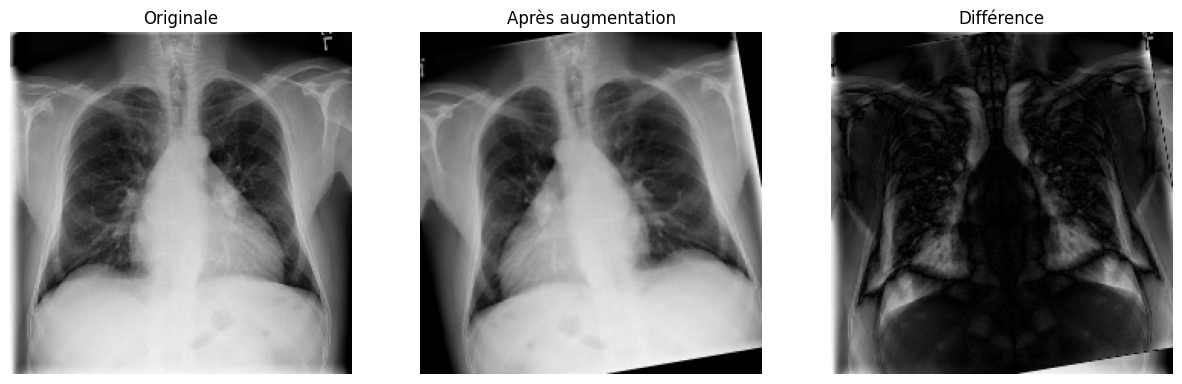

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choisir une image
img_name = valid_images[0]
original_img = load_image_rgb(img_name)
aug_img = augmentations(image=original_img)['image']

# Calculer la différence (valeurs absolues)
diff_img = np.abs(original_img - aug_img)

# Affichage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_img)
axes[0].set_title("Originale")
axes[0].axis("off")

axes[1].imshow(aug_img)
axes[1].set_title("Après augmentation")
axes[1].axis("off")

# Différence
axes[2].imshow(diff_img)
axes[2].set_title("Différence")
axes[2].axis("off")

plt.show()


In [7]:
import pandas as pd

# Pathologies initiales
pathologies = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
    'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Normal'
]

# Comptage avant suppression
counts_before = {p: df[p].sum() for p in pathologies}

# Suppression des pathologies rares (< 20 cas)
rare = [p for p in pathologies if counts_before[p] < 20]
df_filtered = df.drop(columns=rare)
pathologies_after = [p for p in pathologies if p not in rare]

# Comptage après suppression
counts_after = {p: df_filtered[p].sum() for p in pathologies_after}

# Construction du tableau
table = pd.DataFrame({
    'Pathologie': pathologies_after,
    'Avant suppression': [counts_before[p] for p in pathologies_after],
    'Après suppression': [counts_after[p] for p in pathologies_after]
})

print(table)


            Pathologie  Avant suppression  Après suppression
0          Atelectasis                460                460
1         Cardiomegaly                196                196
2             Effusion                487                487
3         Infiltration                830                830
4                 Mass                161                161
5               Nodule                214                214
6            Pneumonia                 65                 65
7         Pneumothorax                199                199
8        Consolidation                205                205
9                Edema                 90                 90
10           Emphysema                125                125
11            Fibrosis                172                172
12  Pleural_Thickening                165                165
13              Hernia                 27                 27
14              Normal               2754               2754
